# Case: diff_1ok_inv_poro_from_mob

Gradient verification for the 1D diffusion case with 1st order kinetics tracer mineral dissolution. Inversion of porosity -> Since it is a pure diffusion case, the gradient should be zero.

The goal here is to verify the correctness of the adjoint state method in HYTEC by comparing the results with the demonstrator's which are considered as correct.

In [1]:
import os
from pathlib import Path
import logging
import copy
import time
from typing import Dict, Iterable
import pyrtid
import pyrtid.forward as dmfwd
import pyrtid.inverse as dminv
import nested_grid_plotter as ngp
import matplotlib.pyplot as plt
from matplotlib.animation import HTMLWriter
from IPython.display import HTML
import numpy as np

import pandas as pd
import scipy as sp
import gstools as gs
from pyrtid.utils import (
    NDArrayFloat,
    NDArrayInt,
    gen_random_ensemble,
    node_number_to_indices,
)

gs.config.USE_RUST = True  # Use the rust implementation of gstools

- Set-up logging level

In [2]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.info("this is a logging test")

INFO:root:this is a logging test


- Check package/software versions

In [3]:
pyrtid.utils.show_versions()

INFO:root:Current version = 0.1.2

INFO:root:Used packages version:

INFO:root:iterative_ensemble_smoother = 0.1.1
INFO:root:gstools                     = 1.5.1
INFO:root:matplotlib                  = 3.7.2
INFO:root:nested_grid_plotter         = 1.0.0
INFO:root:numdiftools                 = 0.9.41
INFO:root:numpy                       = 1.25.2
INFO:root:pyesmda                     = 0.4.3
INFO:root:pypcga                      = 0.1.0
INFO:root:scipy                       = 1.10.1
INFO:root:sksparse                    = 0.4.12
INFO:root:stochopy                    = 2.3.0


- Create a directory to store the exported figures

In [4]:
ipynb_path = os.path.dirname(os.path.realpath("__file__"))
fig_save_path = Path(ipynb_path, "exported_figures")
fig_save_path.mkdir(parents=True, exist_ok=True)  # make sure that the directory exists

- Define some configurations for the plots

In [5]:
# Some configs for the plots
new_rc_params = {
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica", "DejaVu Sans"],
    "font.size": 16,
    "text.usetex": False,
    "savefig.format": "svg",
    "svg.fonttype": "none",  # to store text as text, not as path
    "savefig.facecolor": "w",
    "savefig.edgecolor": "k",
    "savefig.dpi": 300,
    "figure.constrained_layout.use": True,
    "figure.facecolor": "w",
    # "axes.facecolor": "w",
}
csfont = {"fontname": "Comic Sans MS"}
hfont = {"fontname": "Helvetica"}
plt.plot()
plt.close()  # required for the plot to update
plt.rcParams.update(new_rc_params)

## Forward problem

- Define a very simple pure diffusion case in 1D.

In [6]:
# Geometry
nx = 20  # number of voxels along the x axis
ny = 1  # number of voxels along the y axis
dx = 5.9  # voxel dimension along the x axis
dy = 9.26  # voxel dimension along the y axis

# Time parameters
duration_in_d = 25  # duration in days
duration_in_s = 25 * 3600 * 24
dt_init = 3600  # timestep in seconds
dt_max = dt_init * 2
dt_min = dt_init / 2

c0 = 0  # general initial cocentration
# Hydro parameters
D0 = 1e-8  # general initial diffusion coefficient [m2/s]
k0 = 1e-3  # general permeability
w0 = 0.15  # general porosity [fraction]
wdiff = 1.0  # Diffusion
wadv = 0.0  # No avection
# Chemistry parameters
c0 = 0.0  # concentration of species 2 [molal]
c1 = 1e-2  # concentration of species 1 [molal]
M0 = 0.001  # mineral grade [mol/kg] -> kg of water
kv = -1e-7  # kinetic rate,       [mol/m2/s]
moleweight = 270.0  # molar weight [g/mol]
surface = 500  # cm2/g
As = moleweight * surface / 1e4  # specific area [m2/mol]
logK = 3.2
Ks = 1.0 / pow(10, logK)  # solubility constant [no unit]
wmin = 1.0  # Mineral dissolution
stocoef = 10.0
crank_diff = 1.0

# Values for the x axis ()meters
x_positions_in_meters = np.arange(nx) * dx + dx / 2

- Five observation wells

In [7]:
observation_locations = [2, 6, 10, 14, 18]

- Create an initial "bumped" reference distribution for the diffusion, and a flat one for the initial estimation.

In [8]:
porosity_reference: NDArrayFloat = np.ones(nx) * w0
porosity_reference[6:12] = 0.35
porosity_reference = sp.ndimage.gaussian_filter(porosity_reference, sigma=1)

# Estimated diffusion
porosity_estimated: NDArrayFloat = np.ones(nx) * w0 * 1.1

plotter = ngp.NestedGridPlotter(fig_params={"figsize": (8, 5)})
ax = plotter.ax_dict["ax1-1"]
ax.plot(
    x_positions_in_meters, porosity_reference * 100, label="Reference porosity field"
)
ax.plot(
    x_positions_in_meters,
    porosity_estimated * 100,
    label="Initial guess for the diffusion field",
)
ax.set_xlabel("Position (m)", weight="bold")
ax.set_ylabel("Porosity (%)", weight="bold")
# ax.set_yscale("log")
ax.legend(loc="center", bbox_to_anchor=(0.5, -0.3), ncol=2)
ax.set_title("Reference vs. estimated porosity field")
plotter.fig.set_facecolor("w")

# Add some vertical lines to indicate the well
for well_pos in observation_locations:
    ax.plot(
        well_pos * dx - dx / 2,
        np.min((porosity_estimated * 100, porosity_reference * 100)),
        label="obs wells",
        marker="^",
        markersize=10,
        c="r",
        linestyle="none",
    )

fname = "true_vs_estimated_diffusion_field"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

The mineral grades are defined in [mol/kg]. We calculate the conversion factor to obtain ppm and perform easier mass balances.

ConvU: parameter for converting the mineral content in [mol/kg] to metal grade in [ppm]. Note that the ConvU parameter is specific to the Uranium carrier phase: here Uraninite.

$C_{Uraninite}[\frac{mol}{kg}] = convU \times T_{Uranium}[ppm]$


and


$conv_u = \frac{1.023 \times density_{rock}}{238*porosity_{rock} \times 1000}$

Note the 1.023 is the conversion factor from molar mass to molal mass in CHESS.

In [9]:
conv_u: float = 1.023 * 1.63 / (238.0 * w0 * 1000)
logging.info(f"conv_u = {conv_u:.4e}")

INFO:root:conv_u = 4.6708e-05


- Create an initial gaussian spatial distribution for the mineral

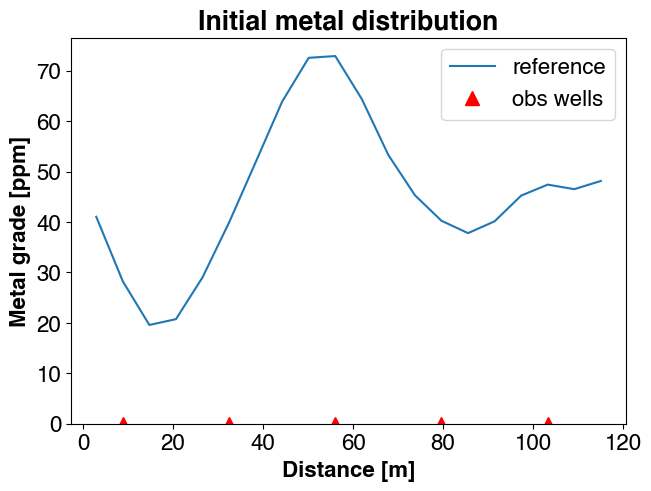

In [10]:
# Create a Gaussian Covariance Model just for the example
# To vary the results, change the seed :)
seed = 6

min_val = 10 * conv_u  # 10 ppm
max_val = 100 * conv_u  # 100 ppm
# Compute the mean and the standard deviation that the distribution should have so that
# <99% of the values are between min and max ~ 6 sigmas
mean = (max_val + min_val) / 2
stdev = (max_val - min_val) / 3 / 2  # std ~ 1/6 of the distribution interval
len_scale = 2.5

initial_grade = gen_random_ensemble(
    model=gs.covmodel.Gaussian,
    n_ensemble=1,
    var=stdev**2,
    len_scale=len_scale,
    mean=mean,
    nx=nx,
    ny=ny,
    seed=seed,
)[0, :, :, 0]

plotter = ngp.NestedGridPlotter()
ax = plotter.ax_dict["ax1-1"]

ax.set_xlabel("Distance [m]", fontweight="bold")
ax.set_ylabel("Metal grade [ppm]", fontweight="bold")
ax.set_ylim(0.0, np.max((initial_grade)) / conv_u * 1.05)
ax.set_title("Initial metal distribution", fontweight="bold")
plotter.fig.set_facecolor("w")


ax.plot(x_positions_in_meters, initial_grade / conv_u, label="reference")

# Add some vertical lines to indicate the well
for well_pos in observation_locations:
    ax.plot(
        well_pos * dx - dx / 2,
        np.min(initial_grade),
        label="obs wells",
        marker="^",
        markersize=10,
        c="r",
        linestyle="none",
    )

plotter.add_axis_legend("ax1-1")

fname = "initial_mineral_field"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

- Note: The initial concentration is null.

### Forward problem in demonstrator

In [11]:
time_params = dmfwd.TimeParameters(
    duration=duration_in_s, dt_init=dt_init, dt_max=dt_max, dt_min=dt_min
)
geometry = dmfwd.Geometry(nx=nx, ny=ny, dx=dx, dy=dx)
fl_params = dmfwd.FlowParameters(k0)
tr_params = dmfwd.TransportParameters(
    diffusion=D0, porosity=w0, crank_nicolson_diffusion=crank_diff
)
gch_params = dmfwd.GeochemicalParameters(
    conc=c0, conc2=c1, grade=M0, kv=kv, As=As, Ks=Ks, stocoef=1.0
)


# We define a function to easily generate a model.
def create_base_model() -> dmfwd.ForwardModel:
    return dmfwd.ForwardModel(geometry, time_params, fl_params, tr_params, gch_params)

- Create two models

In [12]:
model_reference = create_base_model()
model_estimate = create_base_model()
# Initial mineral grade
model_reference.tr_model.set_initial_grade(initial_grade)
model_estimate.tr_model.set_initial_grade(initial_grade)

# Diffusion fields
model_reference.tr_model.porosity[:, 0] = porosity_reference
model_estimate.tr_model.porosity[:, 0] = porosity_estimated

- Run the models

In [13]:
solver_reference = dmfwd.ForwardSolver(model_reference)
solver_reference.solve(is_verbose=True)

solver_estimate = dmfwd.ForwardSolver(model_estimate)
solver_estimate.solve()

INFO:root:max-coupling error at it = 1-1:1655.3407183842917
INFO:root:has-converged ?: False
INFO:root:max-coupling error at it = 1-2:0.00027873446833615034
INFO:root:has-converged ?: False
INFO:root:max-coupling error at it = 1-3:7.776029509187765e-08
INFO:root:has-converged ?: True
INFO:root:max-coupling error at it = 2-1:1.0193344848112829
INFO:root:has-converged ?: False
INFO:root:max-coupling error at it = 2-2:0.00014359087014470528
INFO:root:has-converged ?: False
INFO:root:max-coupling error at it = 2-3:4.0850805405057145e-08
INFO:root:has-converged ?: True
INFO:root:max-coupling error at it = 3-1:0.5147850618982692
INFO:root:has-converged ?: False
INFO:root:max-coupling error at it = 3-2:9.85957113677216e-05
INFO:root:has-converged ?: False
INFO:root:max-coupling error at it = 3-3:2.8607300084360077e-08
INFO:root:has-converged ?: True
INFO:root:max-coupling error at it = 4-1:0.34655579070617737
INFO:root:has-converged ?: False
INFO:root:max-coupling error at it = 4-2:7.61541512

- Top view of the forward concentrations

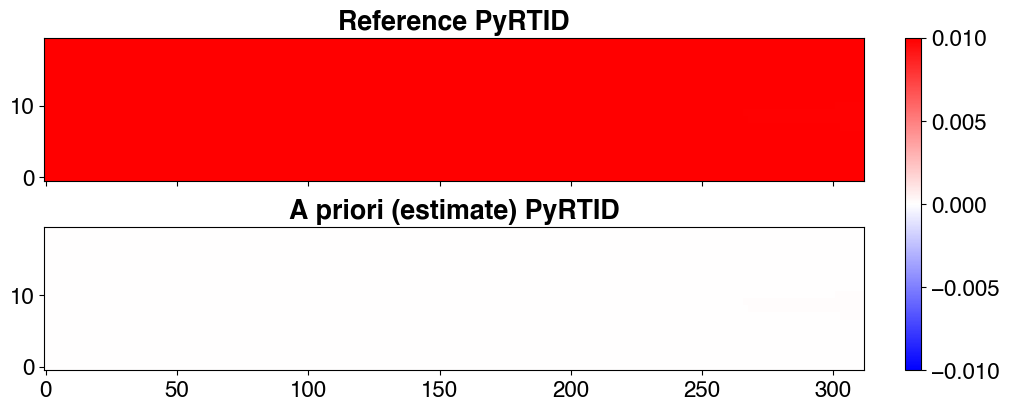

In [14]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 4)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1"], ["ax2-1"]],
            sharey=True,
            sharex=True,
        )
    },
)

ngp.multi_imshow(
    axes=list(plotter.ax_dict.values()),
    fig=plotter.fig,
    data={
        "Reference PyRTID": model_reference.tr_model.conc2[:, 0, :].T,
        "A priori (estimate) PyRTID": model_estimate.tr_model.conc[:, 0, :].T,
    },
    is_symmetric_cbar=True,
)

fname = "tracer_concentration_true_vs_estimate_map"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

- Forward variables at the producer locations

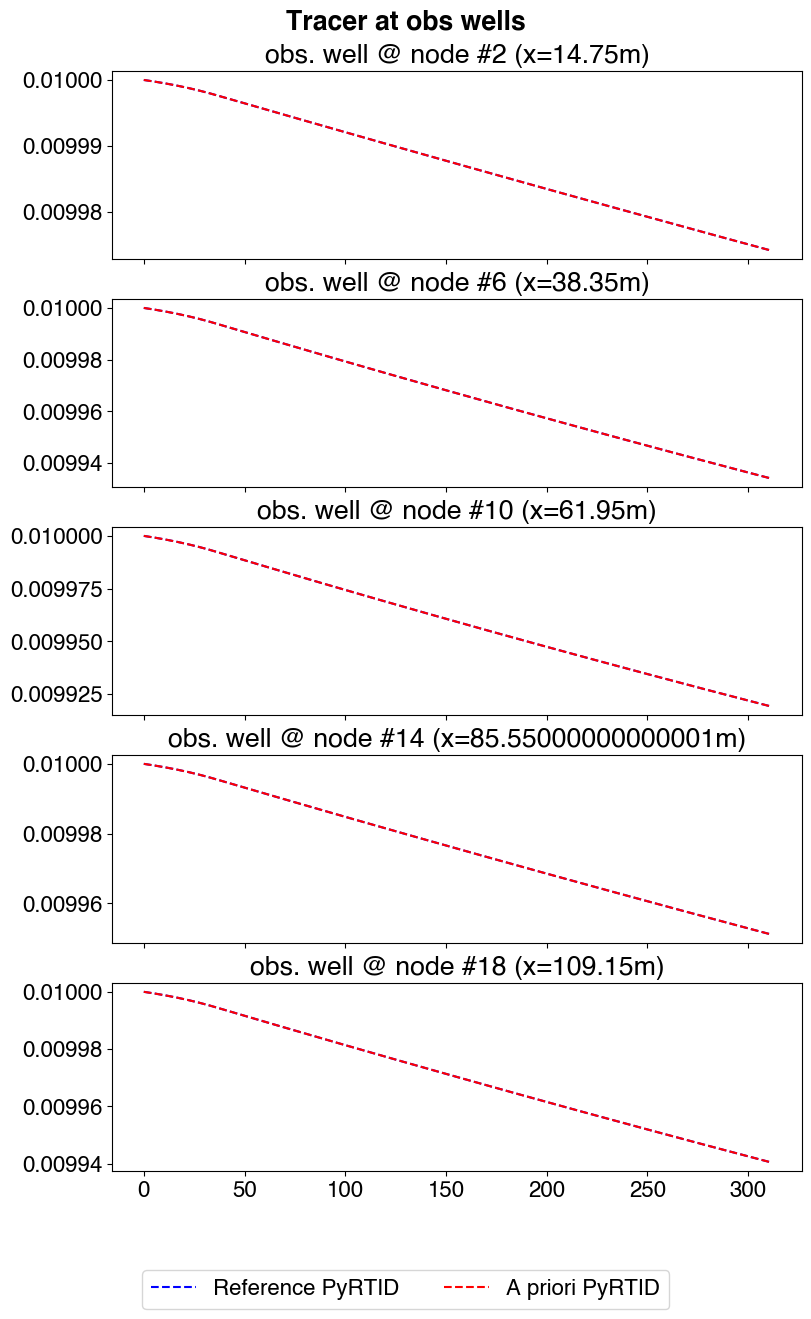

In [15]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (8, 12)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1"], ["ax2-1"], ["ax3-1"], ["ax4-1"], ["ax5-1"]],
            sharey=False,
            sharex=True,
        )
    },
)

for i, node_id in enumerate(observation_locations):
    ax = plotter.get_axis(f"ax{i + 1}-1")
    x = (node_id + 0.5) * geometry.dx
    obs_well_name = f"obs. well @ node #{node_id} (x={x}m)"

    ax.set_title(obs_well_name)
    ax.plot(
        model_reference.tr_model.conc2[node_id, 0, :],
        label="Reference PyRTID",
        c="b",
        linestyle="--",
    )
    ax.plot(
        model_estimate.tr_model.conc2[node_id, 0, :],
        label="A priori PyRTID",
        c="r",
        linestyle="--",
    )

plotter.fig.suptitle("Tracer at obs wells", fontweight="bold")
plotter.add_fig_legend(ncol=2, bbox_y_shift=-0.02)

fname = "tracer_concentration_true_vs_estimate_at_obs_1D"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

In [17]:
plotter = ngp.AnimatedPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 8)},
    subfigs_params={"nrows": 2},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1", "ax1-2"]], sharey=True, sharex=True),
        "fig1": dict(mosaic=[["ax2-1", "ax2-2"]], sharey=True, sharex=True),
    },
)

# Static plot
for ax_name in ["ax1-1", "ax1-2"]:
    plotter.get_axis(ax_name).plot(
        model_reference.tr_model.conc[:, 0, 0] * 1e3, label="Initial", c="red"
    )

# Animated plot
nb_frames = nb_frames = min(model_reference.time_params.nt, 30)


plotter.animated_multi_plot(
    ax_name="ax1-2",
    nb_frames=nb_frames,
    data={
        "Reference": {
            "y": model_reference.tr_model.conc[:, 0, :] * 1e3,
            "kwargs": {"c": "blue"},
        },
        "Estimated": {
            "y": model_estimate.tr_model.conc[:, 0, :] * 1e3,
            "kwargs": {"c": "green", "linestyle": "--"},
        },
    },
    title="PyRTID",
    xlabel="Node #",
)

plotter.animated_multi_plot(
    ax_name="ax2-2",
    nb_frames=nb_frames,
    data={
        "Reference": {
            "y": model_reference.tr_model.grade[:, 0, :] * 1e3,
            "kwargs": {"c": "blue"},
        },
        "Estimated": {
            "y": model_estimate.tr_model.grade[:, 0, :] * 1e3,
            "kwargs": {"c": "green", "linestyle": "--"},
        },
    },
    title="PyRTID",
    xlabel="Node #",
    ylabel="[mmol/kg]",
)


for ax_name in plotter.ax_dict.keys():
    # Add some vertical lines to indicate the well
    for well_pos in observation_locations:
        plotter.ax_dict[ax_name].plot(
            well_pos,
            0.0002,
            label="obs wells",
            marker="^",
            markersize=10,
            c="r",
            linestyle="none",
        )

    plotter.add_axis_legend(ax_name)

plotter.subfigs["fig0"].suptitle("Concentration evolution", fontweight="bold")
plotter.subfigs["fig1"].suptitle("Mineral grade evolution", fontweight="bold")

plotter.close()
plotter.animate(nb_frames=nb_frames)
# Save the animation locally on the computer
fname_html = fig_save_path.joinpath("true_vs_estimate_conc_animation.html")
writer = HTMLWriter(fps=5, embed_frames=True)
writer.frame_format = "svg"  # Ensure svg format
plotter.animation.save(str(fname_html), writer=writer)

# Extract the svg from the html file (for animation in Latex)
ngp.extract_frames_from_embedded_html_animation(fname_html)

# Display the animation
HTML(fname_html.read_text())

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


## Inversion

- Create a function to add some noise to the observations

In [18]:
model_reference.fl_model.head[observation_locations, 0, :].shape

(5, 312)

In [19]:
noise_std: float = 1e-7  # This is an absolute value


def get_white_noise(shape: Iterable[int], seed: int = 2023) -> NDArrayFloat:
    """
    Return the input with some added white noise.

    Note
    ----
    The parameters are hardcoded to be consistent in the notebook.
    Change the function directly.
    """
    mean_noise = 0.0  # mean
    return np.random.default_rng(seed).normal(
        mean_noise, noise_std, size=np.array(shape)
    )


# Generate a white noise
obs_noise: NDArrayFloat = get_white_noise(
    model_reference.fl_model.head[observation_locations, 0, :].shape
)

- Check the intensity of the noise

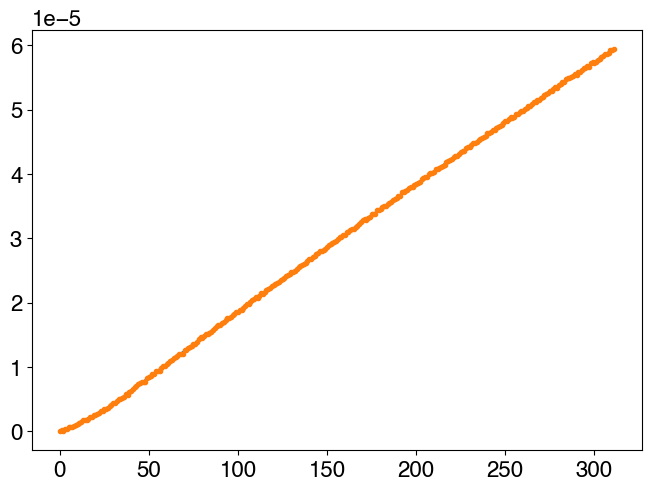

In [20]:
plt.figure(facecolor="w")
plt.plot(model_reference.tr_model.conc[node_id, 0, :])
plt.plot(
    model_reference.tr_model.conc[node_id, 0, :] + obs_noise[0],
    marker=".",
    linestyle="none",
)

### Demonstrator


- Check the correctness of the gradient

In [21]:
param = dminv.AdjustableParameter(
    name=dminv.ParameterName.POROSITY,
    lbounds=0.1,
    ubounds=0.9,
)

from typing import Dict  # Just for linting

observables = []
for i, node_id in enumerate(observation_locations):
    vals = model_reference.tr_model.conc[node_id, 0, :] + obs_noise[i]
    timesteps = np.arange(vals.shape[0])

    observables.append(
        dminv.Observable(
            state_variable=dminv.StateVariable.CONCENTRATION,
            location=(slice(node_id, node_id + 1, 1), slice(None)),
            timesteps=timesteps,
            values=vals,
            uncertainties=noise_std,
        )
    )

# Create an executor to keep track of the adjoint model
solver_config = dminv.ScipySolverConfig(
    solver_name="L-BFGS-B",
    solver_options={"maxfun": 20, "maxiter": 20, "ftol": 1e-4, "gtol": 1e-4},
    is_check_gradient=True,
)
model_adjusted = copy.deepcopy(model_estimate)
inverse_model = dminv.InverseModel(param, observables)
executor = dminv.ScipyInversionExecutor(model_adjusted, inverse_model, solver_config)

# Compute a first objective function
executor.eval_scaled_loss(param.preconditioner(param.values))

is_grad_ok = executor.is_adjoint_gradient_correct()

TypeError: Observable.__init__() got an unexpected keyword argument 'location'

In [ ]:
logging.info(f"Is the gradient correct: {is_grad_ok}")

In [ ]:
param.grad_adj_history[0] / param.grad_fd_history[0]

$\bm{\Sigma}_{\mathrm{post}, ii} = {\bm{\Sigma}_{\mathrm{prior}}}_{ii}$

In [ ]:
# Here comes the python code
plotter = ngp.NestedGridPlotter()

ax = plotter.get_axis("ax1-1")
ax.plot(
    param.grad_adj_history[0] * executor.inv_model.scaling_factor,
    label="Adj. Demonstrator",
    c="b",
)
ax.plot(
    param.grad_fd_history[0] * executor.inv_model.scaling_factor,
    label="FD Demonstrator",
    c="r",
    linestyle="--",
)
# ax.plot(hytec_adjoint_gradient["value"], label="Adj. HYTEC", c="g")
# ax.plot(hytec_fd_gradient["value"], label="FD HYTEC", c="k", linestyle="--")

ax.set_title("Gradient at first iteration")
ax.set_xlabel("Node #")
plotter.add_fig_legend(ncol=2, bbox_y_shift=-0.1)

fname = "gradient_dem_vs_hytec_adj_vs_df_1d_diffusion"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

In [ ]:
plt.plot(
    (param.grad_adj_history[0] - param.grad_fd_history[0])
    * executor.inv_model.scaling_factor
)

In [ ]:
raise ValueError

In [ ]:
param.grad_adj_history[0] / param.grad_fd_history[0]

In [ ]:
(
    param.grad_adj_history[0] - param.grad_fd_history[0]
) / 2 * executor.inv_model.scaling_factor

### HYTEC

In [ ]:
# 1) Copy the base simulation
simu_inverse = copy.deepcopy(simu_estimate)
simu_inverse.update_root_and_name(new_root="simu_inverse", new_name="simu_inverse")

# 2) Add the observation wells
for count, ix in enumerate(observation_locations):
    x = (ix + 0.5) * geometry.dx
    name = f"well_{ix}"
    zone = hymd.Zone(name)
    zone.add_sub_item(
        hymd.Geometry(
            f"rectangle {x},{geometry.dx/2}, {geometry.dx/2},{geometry.dy/2}",
            units="m",
        )
    )
    zone.add_sub_item(hymd.Geochemistry(new_unit.name))
    simu_inverse.model.get_sub_model(hymd.GeometryModel).add_sub_item(zone)
    vals = fwd_conc_reference_hytec[ix, 0, 0, :] + obs_noise[count]

    for species in ["T_Cinet"]:
        # Add the observables for the area
        obs = Observable(
            zone_name=zone.name,
            state_variable=species,
            units="mol/kg",
            timesteps=flux_sample_times,
            time_units="s",
            obs_type=ObservationType.GRID,
            values=vals,
            uncertainties=np.ones(vals.size) * noise_std,
            node_numbers=np.ones(vals.size) * ix,
        )
        simu_inverse.register_observable(
            zone.name, obs, obs_file_path=f"observables/{zone.name}_{species}_o.dat"
        )

# 3) Update the htc file with some options
inv_model = hymd.InverseModel(
    hymd.OptimizationStatus("enabled"),
    hymd.OptimizationSolverConfig(
        "lbfgsb", hymd.AdjointStateStatus("enabled"), hymd.FdGradientCheck("initial")
    ),
    hymd.AdjustedParameterConfig(
        "porosity",
        hymd.Lbound(0.1),
        hymd.Ubound(0.9),
    ),
)
simu_inverse.model.add_sub_item(inv_model)

# number of samples on the adjoint variables
simu_inverse.model.get_sub_model(hymd.SamplingModel).add_sub_item(
    hymd.AdjointGridSampling(nt)
)

# 4)Write the input files
simu_inverse.write_input_files()

runner.run(simu_inverse)

# 7) Read results
simu_inverse.read_hytec_results()  # This fails if not results have been written

- Extract the adjoint variables computed for the first gradient

In [ ]:
print(f"columns = {simu_inverse.handlers.results.optim_res.adjoint_var_columns}")

In [ ]:
adj_conc_hytec = simu_inverse.handlers.results.extract_field_from_adj_var_res(
    field="adjoint-variable{T_Cinet} []", nx=nx
)
adj_grade_hytec = simu_inverse.handlers.results.extract_field_from_adj_var_res(
    field="adjoint-variable{T_Cinet} []", nx=nx
)
adj_conc_hytec.shape

### Results comparison

- Compare objective functions

In [ ]:
print("demonstrator 1st obj function = ", executor.inv_model.loss_scaled_history[0])
print("hytec 1st obj function = ", simu_inverse.handlers.results.optim_res.obj_funs[0])

Because the mineral, tracer and associated observations has been doubled in the case of HYTEC (to test if all is working correctly), the objective function is expected twice higer in the case of HYTEC.

- The adjoint concentrations should be quite the same both in shape and intensity.

In [ ]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 9)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1"], ["ax2-1"], ["ax3-1"]], sharey=True, sharex=True)
    },
)

ngp.multi_imshow(
    axes=list(plotter.ax_dict.values()),
    fig=plotter.fig,
    data={
        "PyRTID": executor.adj_model.a_tr_model.a_conc[:, 0, :].T,
        "HYTEC": adj_conc_hytec[:, 0, 0, :].T,
        "residuals (x100)": (
            executor.adj_model.a_tr_model.a_conc[:, 0, :] - adj_conc_hytec[:, 0, 0, :]
        ).T
        * 100,
    },
    is_symmetric_cbar=True,
)

fname = "adjoint_concentrations_dem_vs_hytec_map"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

In [ ]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 9)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1"], ["ax2-1"], ["ax3-1"]], sharey=True, sharex=True)
    },
)

ngp.multi_imshow(
    axes=list(plotter.ax_dict.values()),
    fig=plotter.fig,
    data={
        "PyRTID": executor.adj_model.a_tr_model.a_grade[:, 0, :].T,
        "HYTEC": -adj_conc_hytec[:, 0, 0, :].T,
        "residuals": (
            executor.adj_model.a_tr_model.a_grade[:, 0, :] + adj_conc_hytec[:, 0, 0, :]
        ).T,
    },
    is_symmetric_cbar=True,
)

fname = "adjoint_concentrations_dem_vs_hytec_map"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

In [ ]:
executor.adj_model.a_tr_model.a_grade[:0, 0]

In [ ]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 9)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1"], ["ax2-1"], ["ax3-1"]], sharey=True, sharex=True)
    },
)

ngp.multi_imshow(
    axes=list(plotter.ax_dict.values()),
    fig=plotter.fig,
    data={
        "PyRTID": executor.adj_model.a_tr_model.a_grade[:, 0, :].T,
        "PyRTID1": executor.adj_model.a_tr_model.a_grade[:, 0, :].T,
        "PyRTID2": executor.adj_model.a_tr_model.a_grade[:, 0, :].T,
        # "HYTEC": adj_grade_hytec[:, 0, 0, :].T,
        # "residuals": (executor.adj_model.a_tr_model.a_grade[:, 0, :] - adj_conc_hytec[:, 0, 0, :]).T,
    },
    is_symmetric_cbar=True,
)

fname = "adjoint_concentrations_dem_vs_hytec_map"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

- Check the adjoint variables at the observation well

In [ ]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (8, 12)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1"], ["ax2-1"], ["ax3-1"], ["ax4-1"], ["ax5-1"]],
            sharey=False,
            sharex=True,
        )
    },
)

for i, node_id in enumerate(observation_locations):
    ax = plotter.get_axis(f"ax{i + 1}-1")
    x = (node_id + 0.5) * geometry.dx
    obs_well_name = f"obs. well @ node #{node_id} (x={x}m)"

    ax.set_title(obs_well_name)
    ax.plot(
        executor.adj_model.a_tr_model.a_conc[node_id, 0, :],
        label="Adj. var. Demonstrator",
        c="g",
    )
    ax.plot(
        adj_conc_hytec[node_id, 0, 0, :], label="Adj. var. HYTEC", c="r", linestyle="--"
    )

plotter.fig.suptitle("Tracer adjoint variable", fontweight="bold")
plotter.add_fig_legend(ncol=2, bbox_y_shift=-0.02)

fname = "adjoint_concentrations_dem_vs_hytec_1D"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

- Get the gradients by the adjoint method and finite differences

Finally, plot the gradients comparison.

In [ ]:
# Get the HYTEC  Adj gradient
hytec_fd_gradient = simu_inverse.handlers.results.optim_res.fd_gradients[0]
hytec_adjoint_gradient = simu_inverse.handlers.results.optim_res.adjoint_gradients[0]

- The demonstrator gradient must be dvided by two to see the equivalence, because the objective function is two times higher in HYTEC. Also, note that the gradient in the demonstrator has 40 values (40 grid cells), while it has 80 in HYTEC (40 grid cells * 2 minerals).

In [ ]:
# Here comes the python code
plotter = ngp.NestedGridPlotter()

ax = plotter.get_axis("ax1-1")
ax.plot(
    param.grad_adj_history[0] / 2 * executor.inv_model.scaling_factor,
    label="Adj. Demonstrator",
    c="b",
)
ax.plot(
    param.grad_fd_history[0] / 2 * executor.inv_model.scaling_factor,
    label="FD Demonstrator",
    c="r",
    linestyle="--",
)
ax.plot(hytec_adjoint_gradient["value"], label="Adj. HYTEC", c="g")
ax.plot(hytec_fd_gradient["value"], label="FD HYTEC", c="k", linestyle="--")

ax.set_title("Gradient at first iteration")
ax.set_xlabel("Node #")
plotter.add_fig_legend(ncol=2, bbox_y_shift=-0.1)

fname = "gradient_dem_vs_hytec_adj_vs_df_1d_diffusion"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

In [ ]:
raise ValueError

# Full optimization

In [ ]:
# 1) Copy the base simulation
simu_inverse2 = copy.deepcopy(simu_inverse)
simu_inverse2.update_root_and_name(
    new_root="simu_inverse_lbfgsb", new_name="simu_inverse_lbfgsb"
)

# 2) Update the htc file with some options
inv_model = hymd.InverseModel(
    hymd.OptimizationStatus("enabled"),
    hymd.OptimizationSolverConfig(
        "lbfgsb",
        hymd.AdjointStateStatus("enabled"),
        hymd.FdGradientCheck("disabled"),
        hymd.MaxNumberFwdModelEval(30),
        hymd.MaxNumberIterations(20),
        hymd.MaxNumberGradientEval(30),
        hymd.ObjFunThreshold(1e-1),
        hymd.GradHistorySize(5),
    ),
    hymd.AdjustedParameterConfig(
        "Min_T_Cinet",
        hymd.Lbound(0.0, units="mol/kg"),
        hymd.Ubound(600.0 * conv_u, units="mol/kg"),
        phase="mineral",
    ),
    hymd.AdjustedParameterConfig(
        "Min_T_Cinet2",
        hymd.Lbound(0.0, units="mol/kg"),
        hymd.Ubound(600.0 * conv_u, units="mol/kg"),
        phase="mineral",
    ),
)
simu_inverse2.model.add_sub_item(inv_model, is_verbose=False)

# 4)Write the input files
simu_inverse2.write_input_files()
runner.run(simu_inverse2)

# 5) Read the results
simu_inverse2.read_hytec_results()

- Get the concentrations

In [ ]:
# Get the results on a 3D grid with the last dimension as time step
fwd_conc_inversed_hytec = simu_inverse2.handlers.results.extract_field_from_grid_res(
    field="T_Cinet [mol/kg]", nx=nx
)

- Get the gradients 

In [ ]:
print(simu_inverse2.handlers.results.optim_res.adjoint_gradients[0].columns)

adjoint_gradients = simu_inverse2.handlers.results.get_adjoint_gradient(
    "Min_T_Cinet", nx=nx, ny=ny
)
fd_gradients = simu_inverse2.handlers.results.get_fd_gradient("diffusion", nx=nx, ny=ny)
adjusted_mineral = simu_inverse2.handlers.results.get_adjusted_parameter_field(
    "Min_T_Cinet", nx=nx, ny=ny
)
obj_funs = simu_inverse2.handlers.results.optim_res.obj_funs

- Align gradients and objective functions: Because of the construction in HYTEC, unless I am mistaken, the objective function and fitted parameter vectors match exactly. On the other hand, there is an uncontrolled mismatch with the gradients due to the solver which, depending on its needs, may have to apply several objective functions in a row or several gradients. This function makes sure that the two match for a good rendering of the animations.

In [ ]:
grad_index = 0
grad_obj_funs = (
    simu_inverse2.handlers.results.optim_res.obj_funs_matching_adjoint_gradients
)

# Example: [3, 4, 4, 5, 7, 8, 8, 9]

aligned_adjoint_gradients = np.empty(
    (*adjoint_gradients[:, :, :, 0].shape, obj_funs.size)
)
aligned_adjoint_gradients.fill(np.nan)

previous_index: int = -1
for i, index in enumerate(grad_obj_funs):
    if index == previous_index:
        continue
    if index > obj_funs.size:
        continue
    previous_index = index
    aligned_adjoint_gradients[:, :, :, index - 1] = adjoint_gradients[:, :, :, i]

# Fill the first missing gradients
# Gradients 1 and 2 in the example
for i2 in range(grad_obj_funs[0] - 1):
    aligned_adjoint_gradients[:, :, :, i2] = aligned_adjoint_gradients[
        :, :, :, grad_obj_funs[0]
    ]

- Get the observations and the predictions vector to plot it against each others

In [ ]:
# obs_vector = simu_inverse2.get_observation_vector()
pred_vector = simu_inverse2.get_results_matching_obs_vector(
    simu_inverse2.get_observables()
)

- Plot the main results

In [ ]:
plotter = ngp.AnimatedPlotter(
    fig_params={"figsize": (10.0, 8.0)}, subfigs_params={"nrows": 2, "ncols": 2}
)

# 1 frame per solver iteration
nb_frames: int = obj_funs.shape[0]

# 1) Gradient evolution
ax = plotter.get_axis("ax1-1")
ax.plot(aligned_adjoint_gradients[:, 0, 0, 0], c="b", label="Initial")
ax.set_title("Gradient")
ax.set_xlabel("Node #")

plotter.animated_multi_plot(
    ax_name="ax1-1",
    nb_frames=nb_frames,
    data={
        "ADJ": {"y": aligned_adjoint_gradients[:, 0, 0, :], "kwargs": {"c": "g"}},
    },
)
plotter.ax_dict["ax1-1"].legend()


# 2) Parameter evolution
ax = plotter.get_axis("ax1-2")
ax.plot(model_true.s_init, c="b", label="Reference")
ax.plot(adjusted_mineral[:, 0, 0, 0], c="orange", label="Initial")

ax.set_title("Diffusivity field")
ax.set_xlabel("Node #")
ax.set_ylabel("[m2/s]")

plotter.animated_multi_plot(
    ax_name="ax1-2",
    nb_frames=nb_frames,
    data={
        "Inverted": {
            "y": adjusted_mineral[:, 0, 0, :],
            "kwargs": {"c": "r", "linestyle": "--"},
        },
    },
)
plotter.ax_dict["ax1-2"].legend()
plotter.ax_dict["ax1-2"].set_yscale("log")

# 3) Objective function
vals = obj_funs
obj_fun_vals = np.full((nb_frames, len(vals)), fill_value=np.nan)
for i in range(len(vals)):
    obj_fun_vals[i, : i + 1] = vals[: i + 1]

plotter.animated_multi_plot(
    ax_name="ax2-1",
    nb_frames=nb_frames,
    data={
        "Obj fun": {"y": obj_fun_vals.T, "kwargs": {"c": "r", "linestyle": "--"}},
    },
    title="Objective function",
    xlabel="Iteration #",
)
plotter.ax_dict["ax2-1"].set_yscale("log")

# 4) Observation vs predicted values
plot_observed_vs_simulated(
    plotter.ax_dict["ax2-2"],
    obs_vector=simu_inverse2.get_observation_vector() * 1000,
    pred_vector=simu_inverse2.get_results_matching_obs_vector(
        simu_inverse2.get_observables()
    )
    * 1000,
    pred_vector_initial=simu_estimate.get_results_matching_obs_vector(
        simu_inverse2.get_observables()
    )
    * 1000,
    units="$mmol.l^{-1}$",
)

plotter.close()
plotter.animate(nb_frames=nb_frames)
# Save the animation locally on the computer
fname_html = fig_save_path.joinpath("m_j_g_animation.html")
writer = HTMLWriter(fps=2, embed_frames=True)
writer.frame_format = "svg"  # Ensure svg format
plotter.animation.save(fname_html, writer=writer)

# Extract the svg from the html file (for animation in Latex)
ngp.extract_frames_from_embedded_html_animation(fname_html)

# Display the animation
HTML(fname_html.read_text())

- Plot the concentrations

In [ ]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (8, 12)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1"], ["ax2-1"], ["ax3-1"], ["ax4-1"], ["ax5-1"]],
            sharey=False,
            sharex=True,
        )
    },
)

for i, node_id in enumerate(observation_locations):
    ax = plotter.get_axis(f"ax{i + 1}-1")
    x = (node_id + 0.5) * model_true.dx
    obs_well_name = f"obs. well @ node #{node_id} (x={x}m)"

    ax.set_title(obs_well_name)
    ax.plot(
        make_noisy(fwd_conc_true_hytec[node_id, 0, 0, :]),
        label="Reference HYTEC (noisy)",
        c="g",
        linestyle="none",
        marker=".",
        alpha=0.5,
    )
    ax.plot(fwd_conc_estimate_hytec[node_id, 0, 0, :], label="A priori HYTEC", c="r")
    ax.plot(
        fwd_conc_inversed_hytec[node_id, 0, 0, :], label="Post inversion HYTEC", c="b"
    )

plotter.fig.suptitle("Tracer at obs wells", fontweight="bold")
plotter.add_fig_legend(ncol=2, bbox_y_shift=-0.02)

fname = "tracer_concentrations_after_inversion"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)